In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
plt.rc('font',family='Arial')
import pickle
import random
from sklearn.metrics import roc_curve, auc, roc_auc_score
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')

from ipynb.fs.full.Koazk_Similarity_Score_Algorithm import weights, similarity_score

In [2]:
p_cug_sequences = list(np.load('Total Data/cug_pos.npy',allow_pickle=True))

p_distribution_cug = []


for i in p_cug_sequences:
    p_distribution_cug=np.append(p_distribution_cug,similarity_score(i))
    
    
p_gug_sequences = list(np.load('Total Data/gug_pos.npy',allow_pickle=True))

p_distribution_gug = []


for i in p_gug_sequences:
    p_distribution_gug=np.append(p_distribution_gug,similarity_score(i))
    

p_uug_sequences = list(np.load('Total Data/uug_pos.npy',allow_pickle=True))

p_distribution_uug = []


for i in p_uug_sequences:
    p_distribution_uug=np.append(p_distribution_uug,similarity_score(i))
    
distribution_near_cognate= np.array(list(p_distribution_cug)+list(p_distribution_gug)+list(p_distribution_uug))    

In [3]:
p_noncug_sequences = list(np.load('Total Data/cug_neg.npy',allow_pickle=True))



p_distribution_noncug= []


for i in p_noncug_sequences:
    p_distribution_noncug=np.append(p_distribution_noncug,similarity_score(i))
    
p_nongug_sequences = list(np.load('Total Data/gug_neg.npy',allow_pickle=True))


p_distribution_nongug= []


for i in p_nongug_sequences:
    p_distribution_nongug=np.append(p_distribution_nongug,similarity_score(i))    
    
p_nonuug_sequences = list(np.load('Total Data/uug_neg.npy',allow_pickle=True))



p_distribution_nonuug= []


for i in p_nonuug_sequences:
    p_distribution_nonuug=np.append(p_distribution_nonuug,similarity_score(i))
    
p_distribution_nonnear_cognate= list(p_distribution_noncug)+list(p_distribution_nongug)+list(p_distribution_nonuug)

In [4]:
randoms=100000 
possible = ['a','t','c','g']
ran_sequences=[0]*randoms
for i in range(randoms):
    sequence=''.join(random.choices(possible, k=23))
    ran_sequences[i]=sequence

distribution_ran = []

    
for i in ran_sequences:
    distribution_ran=np.append(distribution_ran,similarity_score(i))

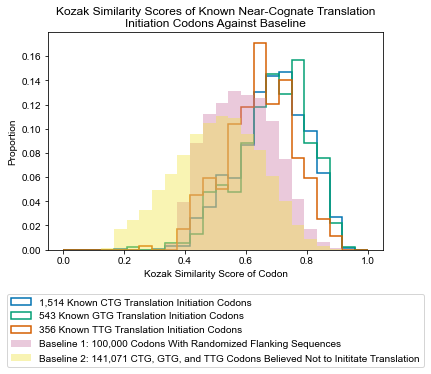

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)    
ax.hist(p_distribution_cug,bins = np.linspace(0,1,25),histtype=u'step',alpha=1,
           weights=np.ones(len(p_distribution_cug)) / len(p_distribution_cug),
          label = "1,514 Known CTG Translation Initiation Codons",linewidth=1.5)

ax.hist(p_distribution_gug,np.linspace(0,1,25),histtype=u'step',alpha=1,
           weights=np.ones(len(p_distribution_gug)) / len(p_distribution_gug),
          label = "543 Known GTG Translation Initiation Codons",linewidth=1.5)

ax.hist(p_distribution_uug,np.linspace(0,1,25),histtype=u'step',alpha=1,
           weights=np.ones(len(p_distribution_uug)) / len(p_distribution_uug),
          label = "356 Known TTG Translation Initiation Codons",linewidth=1.5)

ax.hist(distribution_ran,np.linspace(0,1,25),histtype=u'stepfilled',alpha=0.4,
           weights=np.ones(len(distribution_ran)) / len(distribution_ran),
          label = "Baseline 1: 100,000 Codons With Randomized Flanking Sequences",linewidth=1.5)

ax.hist(p_distribution_nonnear_cognate,np.linspace(0,1,25),histtype=u'stepfilled',alpha=0.4,
           weights=np.ones(len(p_distribution_nonnear_cognate)) / len(p_distribution_nonnear_cognate),
          label = "Baseline 2: 141,071 CTG, GTG, and TTG Codons Believed Not to Inititate Translation",linewidth=1.5)


title = ax.set_title("\n".join(wrap('Kozak Similarity Scores of Known Near-Cognate Translation Initiation Codons Against Baseline', 60)))
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.18))
plt.xlabel("Kozak Similarity Score of Codon")
plt.ylabel("Proportion")
plt.show()

#### Due to sampling strategy, results may marginally vary per run

In [6]:
values = np.arange(0.55,0.66,0.001)

runs=1000

subsets = []

for i in range(runs):
        distribution_nonnear_cognate= np.array(random.sample(list(p_distribution_nonnear_cognate),len(distribution_near_cognate)))
        
        subsets.append(list(distribution_nonnear_cognate)+list(distribution_near_cognate))

errors = []

for val in values:
    error = [0]*runs
    for i in range(runs):
        distribution_nonnear_cognate= subsets[i][0:len(distribution_near_cognate)]
        error[i]=(sum(distribution_nonnear_cognate>val)+sum(distribution_near_cognate<val))/(len(distribution_nonnear_cognate)+len(distribution_near_cognate))
        
    errors.append([np.mean(error),val])


# Finding Best Score Threshold to Miminize Model Classification Error

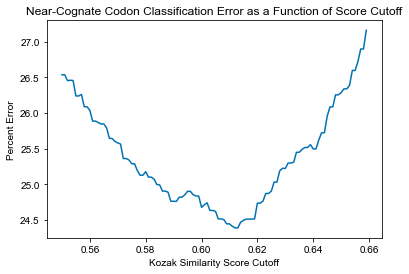

In [7]:
errors_ =[]

for i in errors:
    errors_.append(i[0]*100)
    
fig = plt.figure()    
plt.plot(values, errors_)
plt.xlabel('Kozak Similarity Score Cutoff')
plt.ylabel('Percent Error')


plt.title('Near-Cognate Codon Classification Error as a Function of Score Cutoff')
plt.show()

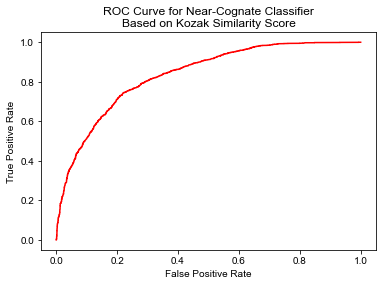

AUC: 0.835


In [8]:
cutoff=min(errors)[1]

distribution_nonnear_cognate= np.array(random.sample(list(p_distribution_nonnear_cognate),len(distribution_near_cognate)))

total_near_cognate_distribution=np.append(distribution_nonnear_cognate,distribution_near_cognate)/(2*cutoff) #normalizing scores

true_classes=np.append(np.zeros(len(distribution_nonnear_cognate)),np.ones(len(distribution_near_cognate)))

        
fpr, tpr, thresholds = roc_curve(true_classes, total_near_cognate_distribution)
        
plt.plot(fpr, tpr,color='red')
plt.title("\n".join(wrap('ROC Curve for Near-Cognate Classifier Based on Kozak Similarity Score', 40)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
auc = roc_auc_score(true_classes, total_near_cognate_distribution)

print('AUC: %.3f' % auc)


# Kozak Similarity Score as a Metric of Near-Cognate Codon Likelihood to Inititate Translation

In [9]:
cutoffs = np.arange(0,1,0.02)

runs =1000

mean_proportions_translating = []

subsets = []

for i in range(runs):
        distribution_nonnear_cognate= np.array(random.sample(list(p_distribution_nonnear_cognate),len(distribution_near_cognate)))
        
        subsets.append(list(distribution_nonnear_cognate)+list(distribution_near_cognate))

for cutoff in cutoffs:
    proportions_translating = [0]*runs
    for i in range(runs):
        distribution_nonnear_cognate= subsets[i][0:len(distribution_near_cognate)]
        
        proportions_translating[i] = sum(distribution_near_cognate>cutoff)/(sum(distribution_near_cognate>cutoff)+sum(distribution_nonnear_cognate>cutoff))
                
    mean_proportions_translating.append([np.mean(proportions_translating),cutoff])

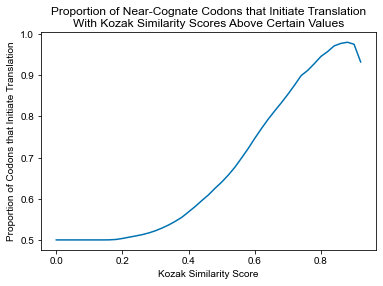

In [10]:
mean_proportions_translating_vals = [i[0] for i in mean_proportions_translating]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(cutoffs, mean_proportions_translating_vals)
plt.xlabel('Kozak Similarity Score')
plt.ylabel('Proportion of Codons that Initiate Translation')

title = ax.set_title("\n".join(wrap('Proportion of Near-Cognate Codons that Initiate Translation With Kozak Similarity Scores Above Certain Values', 60)))
plt.show()